In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) 
from sidm.tools import ffschema, sidm_processor, utilities, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
importlib.reload(cutflow)
# plotting
import matplotlib.pyplot as plt
import mplhep as hep

# Load style sheet
# plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

# h, bins = np.histogram(np.random.random(1000))
# fig, ax = plt.subplots()
# hep.histplot(h, bins)

utilities.set_plot_style()

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

/home/cms-jovyan/SIDM/sidm/studies/../../sidm/tools/scaleout.py:12: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(PipInstall(packages=dependencies, pip_options=["--upgrade"]))


Connection method: Direct,
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,
Comm: tls://192.168.235.39:8786,Workers: 0
Dashboard: /user/yfv2ev@virginia.edu/proxy/8787/status,Total threads: 0
Started: 1 week ago,Total memory: 0 B


In [3]:
SIDM_samples = [
    "2Mu2E_100GeV_1p2GeV_9p6mm", 
    "4Mu_100GeV_1p2GeV_9p6mm",
    
    "2Mu2E_1000GeV_0p25GeV_0p02mm",
    "4Mu_1000GeV_0p25GeV_0p02mm",

    "4Mu_100GeV_5GeV_0p4mm"
]


samples = [
    "DYJetsToLL_M10to50", # Background
    "DYJetsToLL_M50",
    
    "QCD_Pt15to20", #Works
    "QCD_Pt20to30", #issue, needs many files to fill all histograms
    #"QCD_Pt30to50", #Broken, throws KeyError: 'akjet_ak4PFJetsCHS_jetid' - now fixed in ffschema
    "QCD_Pt50to80", #Works
    "QCD_Pt80to120", #Works
    #"QCD_Pt120to170", #Broken, Exception: Failed processing file: WorkItem(dataset='QCD_Pt120to170' ...)
    "QCD_Pt170to300", #Works
    "QCD_Pt300to470", #Works
    "QCD_Pt470to600", #Works
    "QCD_Pt600to800", #Works
    "QCD_Pt800to1000", #Works
    "QCD_Pt1000toInf", #Works
    
    "TTJets",
    "WW",
    "WZ",
    "ZZ",
]

for sample in SIDM_samples:
    samples.append(sample)

for sample in samples:
    print("Sample: " + sample)
    
fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=16) #max_files argument was removed, so it defaults to use all the files in each sample
#fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=8) #CHANGED: background appears to use v2 ntuples instead of v4

Sample: DYJetsToLL_M10to50
Sample: DYJetsToLL_M50
Sample: QCD_Pt15to20
Sample: QCD_Pt20to30
Sample: QCD_Pt50to80
Sample: QCD_Pt80to120
Sample: QCD_Pt170to300
Sample: QCD_Pt300to470
Sample: QCD_Pt470to600
Sample: QCD_Pt600to800
Sample: QCD_Pt800to1000
Sample: QCD_Pt1000toInf
Sample: TTJets
Sample: WW
Sample: WZ
Sample: ZZ
Sample: 2Mu2E_100GeV_1p2GeV_9p6mm
Sample: 4Mu_100GeV_1p2GeV_9p6mm
Sample: 2Mu2E_1000GeV_0p25GeV_0p02mm
Sample: 4Mu_1000GeV_0p25GeV_0p02mm
Sample: 4Mu_100GeV_5GeV_0p4mm


In [4]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client),
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "2mu2e","4mu",
            "baseNoLj"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.
p = sidm_processor.SidmProcessor(
    channels, ["base"]) # not sure if base_plus_gen applies to the background

# test if processor is serializable
import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))


output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [5]:
# Post-processing, combines background samples into larger sets.
# This applies to cutflows and to histograms
hist_set = "base"
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu[hist_set]) #To change the histograms used, swap "base" for the other collections

sample_list = ["DY_Jets", "QCD_Jets", "DiBoson_Jets", "TTJets", "Total Background"]

for sample in samples:
    if not(sample[0] == 'D') and not(sample[0] == 'Q') and not((sample[0] == 'W' or sample[0] == 'Z')) and not(sample[0] == 'T'):
        sample_list.append(sample)

#Combine Drell-Yan
keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
DY_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}
    
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
DY_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}
    
keys = list(output['out']["DYJetsToLL_M50"]["cutflow"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["cutflow"][k] for k in keys}
for channel in channels:
    DY_Cutflow[channel] = DY_Cutflow[channel] + temp[channel]
keys = list(output['out']["DYJetsToLL_M50"]["hists"].keys())[:]
temp = {k: output['out']["DYJetsToLL_M50"]["hists"][k] for k in keys}    
for hist_name in collection:
    DY_Hists[hist_name] = DY_Hists[hist_name] + temp[hist_name]

#Combine QCD
keys = list(output['out']["QCD_Pt15to20"]["cutflow"].keys())[:]
QCD_Cutflow = {k: output['out']["QCD_Pt15to20"]["cutflow"][k] for k in keys}
keys = list(output['out']["QCD_Pt15to20"]["hists"].keys())[:]
QCD_Hists = {k: output['out']["QCD_Pt15to20"]["hists"][k] for k in keys}
    
for sample in samples:
    if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            QCD_Cutflow[channel] = QCD_Cutflow[channel] + temp[channel]
                
        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            QCD_Hists[hist_name] = QCD_Hists[hist_name] + temp[hist_name]

#Combine diboson
keys = list(output['out']["WW"]["hists"].keys())[:]
DiBoson_Hists = {k: output['out']["WW"]["hists"][k] for k in keys}

keys = list(output['out']["WW"]["cutflow"].keys())[:]
DiBoson_Cutflow = {k: output['out']["WW"]["cutflow"][k] for k in keys}

for sample in ["WZ", "ZZ"]:
    keys = list(output['out']["WZ"]["cutflow"].keys())[:]
    temp = {k: output['out']["WZ"]["cutflow"][k] for k in keys}
    for channel in channels:
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + temp[channel]

    keys = list(output['out'][sample]["hists"].keys())[:]
    temp = {k: output['out'][sample]["hists"][k] for k in keys}
    for hist_name in collection:
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + temp[hist_name]

#Add ttbar
keys = list(output['out']["TTJets"]["hists"].keys())[:]
TT_Hists = {k: output['out']["TTJets"]["hists"][k] for k in keys}

keys = list(output['out']["TTJets"]["cutflow"].keys())[:]
TT_Cutflow = {k: output['out']["TTJets"]["cutflow"][k] for k in keys}

#Combine total background
keys = list(output['out']["DYJetsToLL_M10to50"]["hists"].keys())[:]
bg_Hists = {k: output['out']["DYJetsToLL_M10to50"]["hists"][k] for k in keys}

keys = list(output['out']["DYJetsToLL_M10to50"]["cutflow"].keys())[:]
bg_Cutflow = {k: output['out']["DYJetsToLL_M10to50"]["cutflow"][k] for k in keys}

for sample in samples:
    if ((sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') or (sample[0] == 'T')) and (sample != "DYJetsToLL_M10to50"):
        keys = list(output['out'][sample]["cutflow"].keys())[:]
        temp = {k: output['out'][sample]["cutflow"][k] for k in keys}
        for channel in channels:
            bg_Cutflow[channel] = bg_Cutflow[channel] + temp[channel]

        keys = list(output['out'][sample]["hists"].keys())[:]
        temp = {k: output['out'][sample]["hists"][k] for k in keys}
        for hist_name in collection:
            bg_Hists[hist_name] = bg_Hists[hist_name] + temp[hist_name]

In [6]:
#This defines a function to break down the samples and make individual subplots for each one.
#Fix: should set the specific range as a parameter. For now, it uses [ :1200j]. Could be an issue in the future.
def plotSamples(hists, channel, errorBars, densityPlot, sample_0=sample_list, fullBg=True):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(samples)
    nhists = len(hists)
    if (nplots <= 6): ncol, nrow = nplots, 1
    else: ncol, nrow = 6, (nplots-1)//6 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
    for i in range(nplots):
        plt.subplot(nrow, ncol, i+1)
        j = 0
        if "DY_Jets" in samples and DY_Flag == False:
            for j in range(nhists):
                utilities.plot(DY_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
        elif "QCD_Jets" in samples and QCD_Flag == False:
            for j in range(nhists):
                utilities.plot(QCD_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
        elif "DiBoson_Jets" in samples and DB_Flag == False:
            for j in range(nhists):
                utilities.plot(DiBoson_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
        elif "TTJets" in samples and TT_Flag == False:
            for j in range(nhists):
                utilities.plot(TT_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
        elif "Total Background" in samples and Tot_BG_Flag == False:
            for j in range(nhists):
                utilities.plot(bg_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
        else:
            for j in range(nhists):
                utilities.plot(out[samples[i]]["hists"][hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
        plt.legend(hists)
        plt.title(samples[i])

In [7]:
#DY_Output = output['out']["DYJetsToLL_M10to50"]["hists"]["muon_pt"] + output['out']["DYJetsToLL_M50"]["hists"]["muon_pt"]
# Trying to combine all DY processes into one element
# This would use all DY processes at once
# Combining the files manually in the background (combining the categories of <50 and >50) wouldn't work, since only a few files are used overall.
# Should work going forward with DY_Output['hists']["muon_pt"]["baseNoLj", :], etc.
# from coffea.processor import accumulate
#double_out = accumulate([output["out"], output["out"]])
#DY = accumulate(output['out']["DYJetsToLL_M10to50"], output['out']["DYJetsToLL_M10to50"])
#DY = output['out']["DYJetsToLL_M10to50"]["hists"] + output['out']["DYJetsToLL_M50"]["hists"]
#print(output['out']["DYJetsToLL_M10to50"])
#print(output['out']["DYJetsToLL_M10to50"])

Text(0.5, 1.0, 'Combined BG')

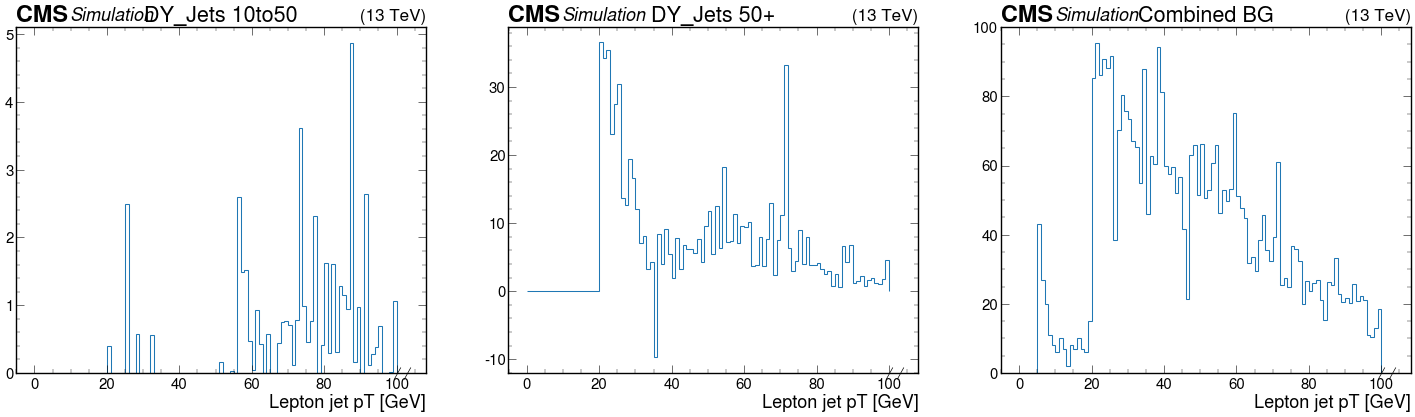

In [8]:
plt.subplots(1,3, figsize=(36, 9))
plt.subplot(1, 3, 1)
utilities.plot(out["DYJetsToLL_M10to50"]["hists"]["lj_pt"]["baseNoLj", :], density=False, yerr=False)
plt.title("DY_Jets 10to50")
plt.subplot(1, 3, 2)
utilities.plot(out["DYJetsToLL_M50"]["hists"]["lj_pt"]["baseNoLj", :], density=False, yerr=False)
plt.title("DY_Jets 50+")
plt.subplot(1, 3, 3)
#DY_plot = utilities.plot(out["DYJetsToLL_M10to50"]["hists"]["muon_pt"]["baseNoLj", :], density=True) + utilities.plot(out["DYJetsToLL_M50"]["hists"]["muon_pt"]["baseNoLj", :], density=True)
utilities.plot(bg_Hists["lj_pt"]['baseNoLj', :], density = False, yerr=False)
plt.title("Combined BG")
# Shows the issue with combining plots -- all combined plots are overwritten with the sum

In [9]:
bg_Cutflow["2mu2e"].print_table(fraction=True)

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                  5.3           5.3             5.3
2mu2e                    0.5           9.8             0.5


In [10]:
QCD_Cutflow["2mu2e"].print_table(fraction=True)
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)


cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                  0.4           0.4             0.4
2mu2e                    0.2          39.6             0.2


In [11]:
DiBoson_Cutflow["2mu2e"].print_table(fraction=True)

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 67.5          67.5            67.5
2mu2e                   34.4          50.9            34.4


In [12]:
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["2mu2e"].print_table(fraction=True)
print()
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["baseNoLj"].print_table()
print()

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 19.1          19.1            19.1
4mu                      0.0           0.0             0.0

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 19.1          19.1            19.1
2mu2e                   19.1         100.0            19.1

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection             38085.8      38085.8
PV filter                38085.8  

In [13]:
output['out']["4Mu_100GeV_1p2GeV_9p6mm"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["4Mu_100GeV_1p2GeV_9p6mm"]["cutflow"]["2mu2e"].print_table(fraction=True)
print()

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.9          99.9            99.9
>=2 LJs                 35.5          35.5            35.4
4mu                     35.4          99.8            35.4

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.9          99.9            99.9
>=2 LJs                 35.5          35.5            35.4
2mu2e                    0.1           0.2             0.1



/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/p

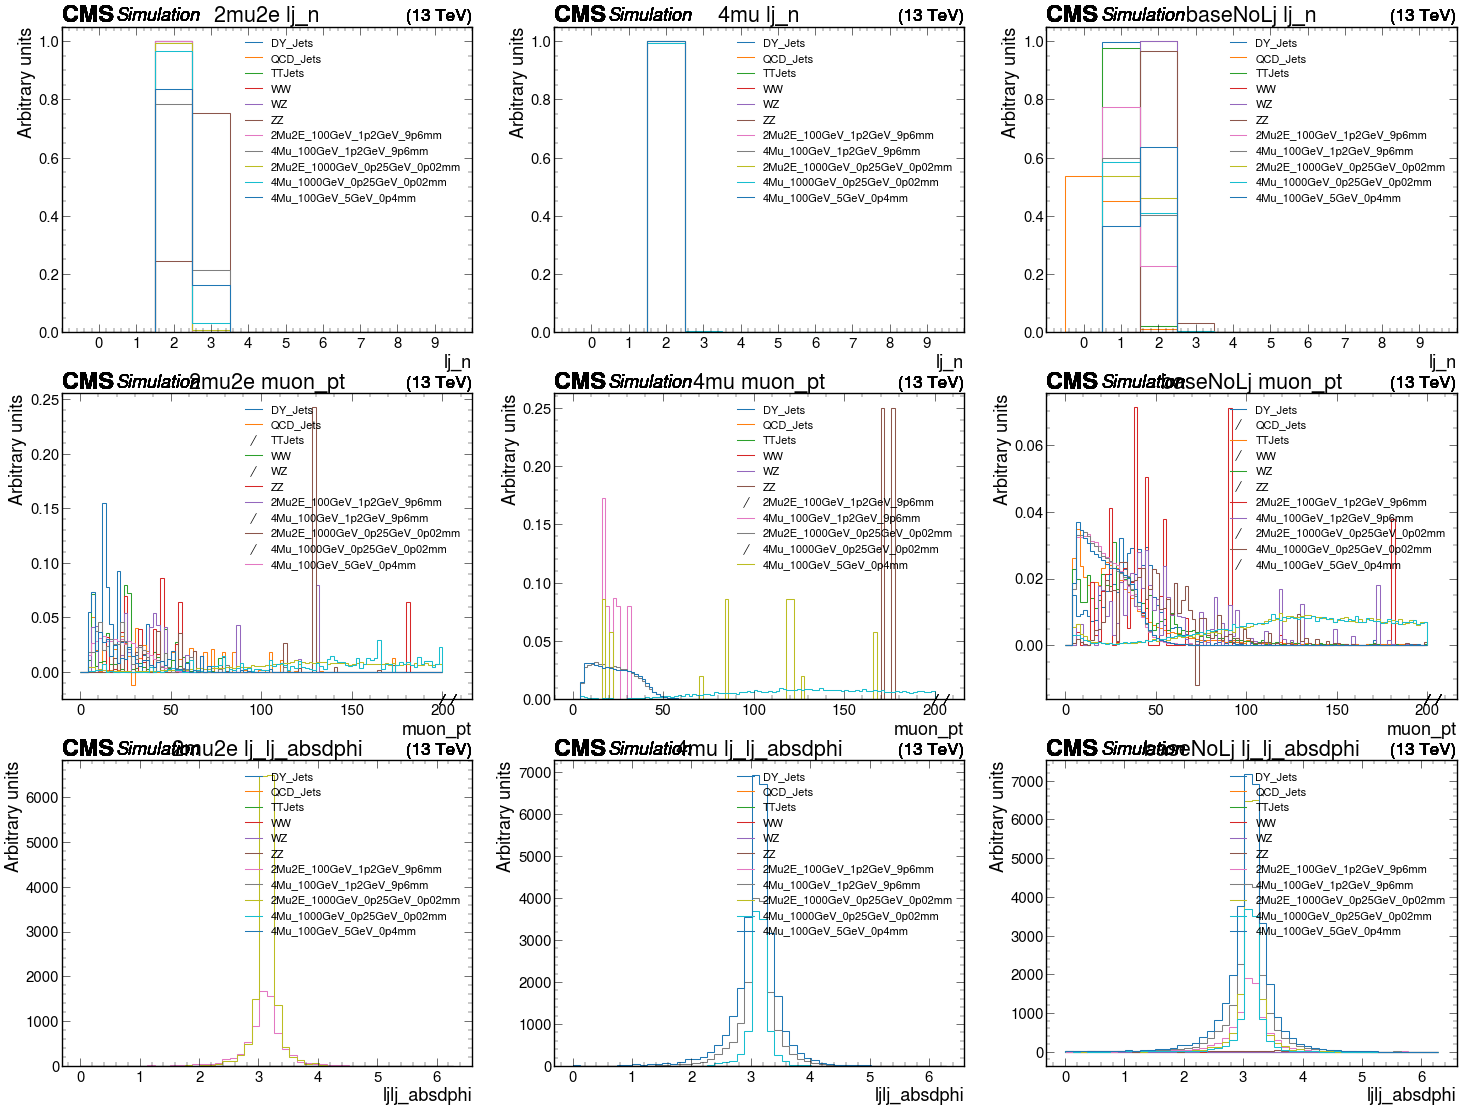

In [14]:
nrow = 3
ncol = 3
nplots = nrow*ncol
sample_list = ["DY_Jets", "QCD_Jets"]
for sample in samples:
    if (sample[0] != 'D') and (sample[0] != 'Q'):
        sample_list.append(sample)

plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
figure_plotted_hists = [["lj_n", True], ["muon_pt", True], ["lj_lj_absdphi", False]]
# each element is ["Hist_name", Density]

for i in range(len(figure_plotted_hists)):
    for j in range(1, ncol+1):
        plt.subplot(nrow, ncol, j+i*ncol)
        
        utilities.plot(DY_Hists[figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])
        utilities.plot(QCD_Hists[figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])

        for sample in sample_list:
            if sample[0] != 'D' and sample[0] != 'Q':
                utilities.plot(out[sample]["hists"][figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])

        plt.ylabel("Arbitrary units")
        plt.legend(sample_list, loc=1, prop={'size': 16})
        plt.title(channels[j-1] + ' ' + figure_plotted_hists[i][0])

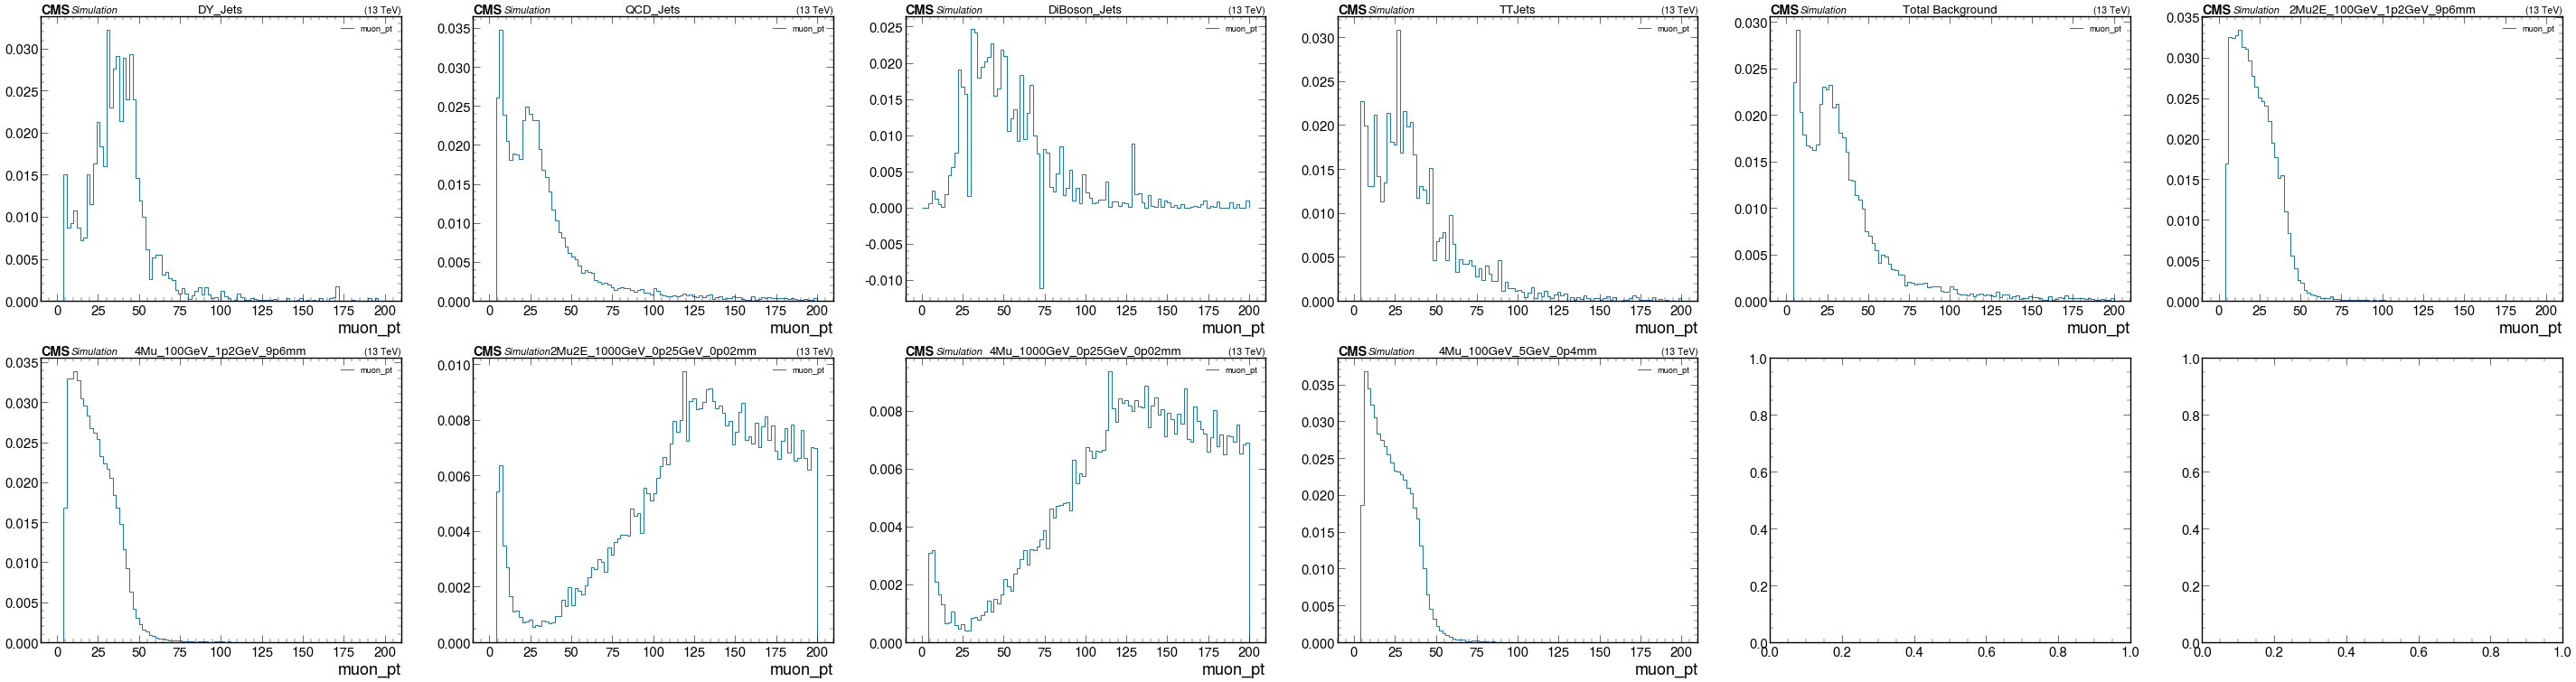

In [15]:
plotSamples(["muon_pt"], "baseNoLj", False, True)

From the muon_pt plots, it's clear that many of the background types do not have enough data to support useful histograms. Even in the baseNoLj channel, WW and ZZ especially have few samples. One of the ZZ bins is negative and the overall shape follows a trend, but is small enough that some bins are nearly empty. Furthermore, it is clear from a first glance what QCD bin was excluded (30-50). This needs to be fixed to smooth out the plot.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f57da2edb80>, errorbar=None, legend_artist=None)]

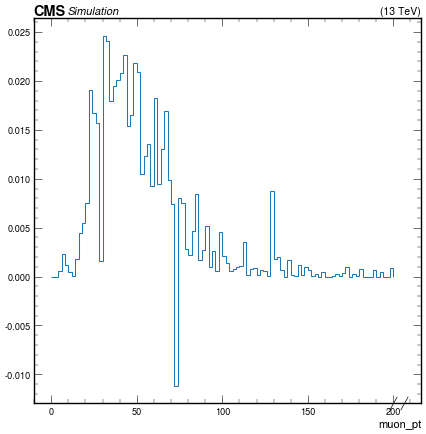

In [16]:
utilities.plot(DiBoson_Hists["muon_pt"]["baseNoLj", :200j], yerr=False, density=True)

['DY_Jets', 'QCD_Jets', 'TTJets', 'WW', 'WZ', 'ZZ', '2Mu2E_100GeV_1p2GeV_9p6mm', '4Mu_100GeV_1p2GeV_9p6mm', '2Mu2E_1000GeV_0p25GeV_0p02mm', '4Mu_1000GeV_0p25GeV_0p02mm', '4Mu_100GeV_5GeV_0p4mm']


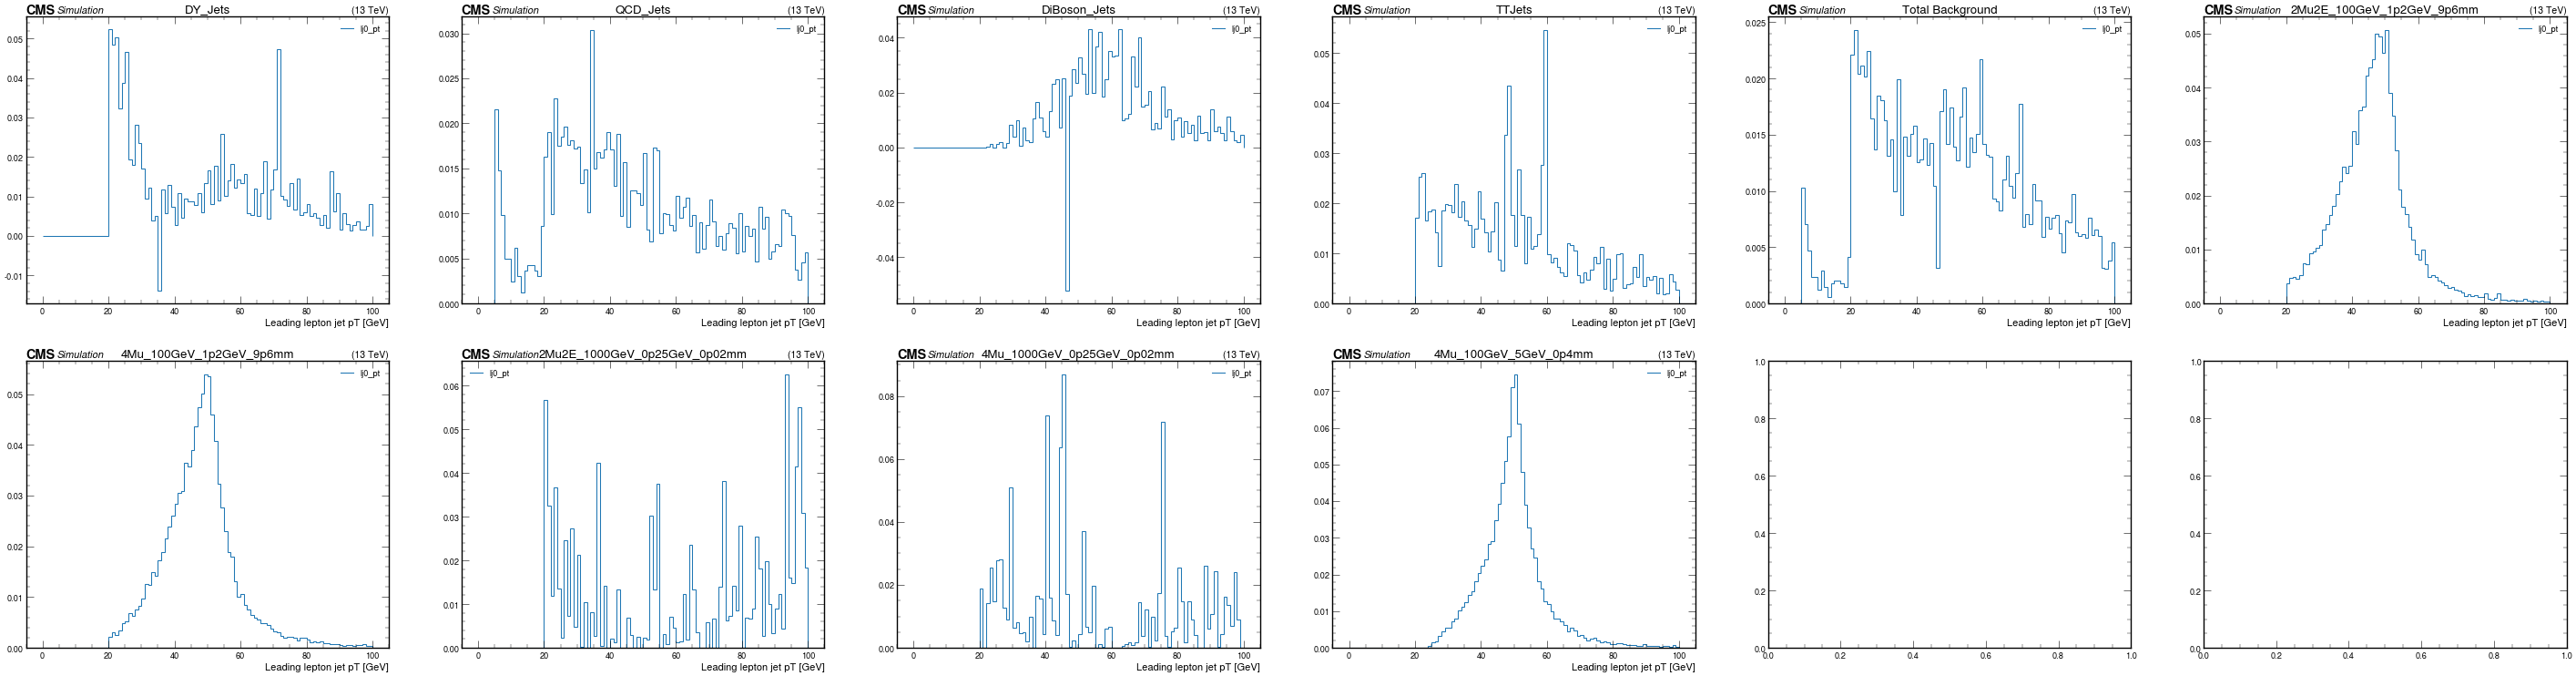

In [17]:
print(sample_list)

plotSamples(["lj0_pt"], "baseNoLj", False, True)

['DY_Jets', 'QCD_Jets', 'TTJets', 'WW', 'WZ', 'ZZ', '2Mu2E_100GeV_1p2GeV_9p6mm', '4Mu_100GeV_1p2GeV_9p6mm', '2Mu2E_1000GeV_0p25GeV_0p02mm', '4Mu_1000GeV_0p25GeV_0p02mm', '4Mu_100GeV_5GeV_0p4mm']


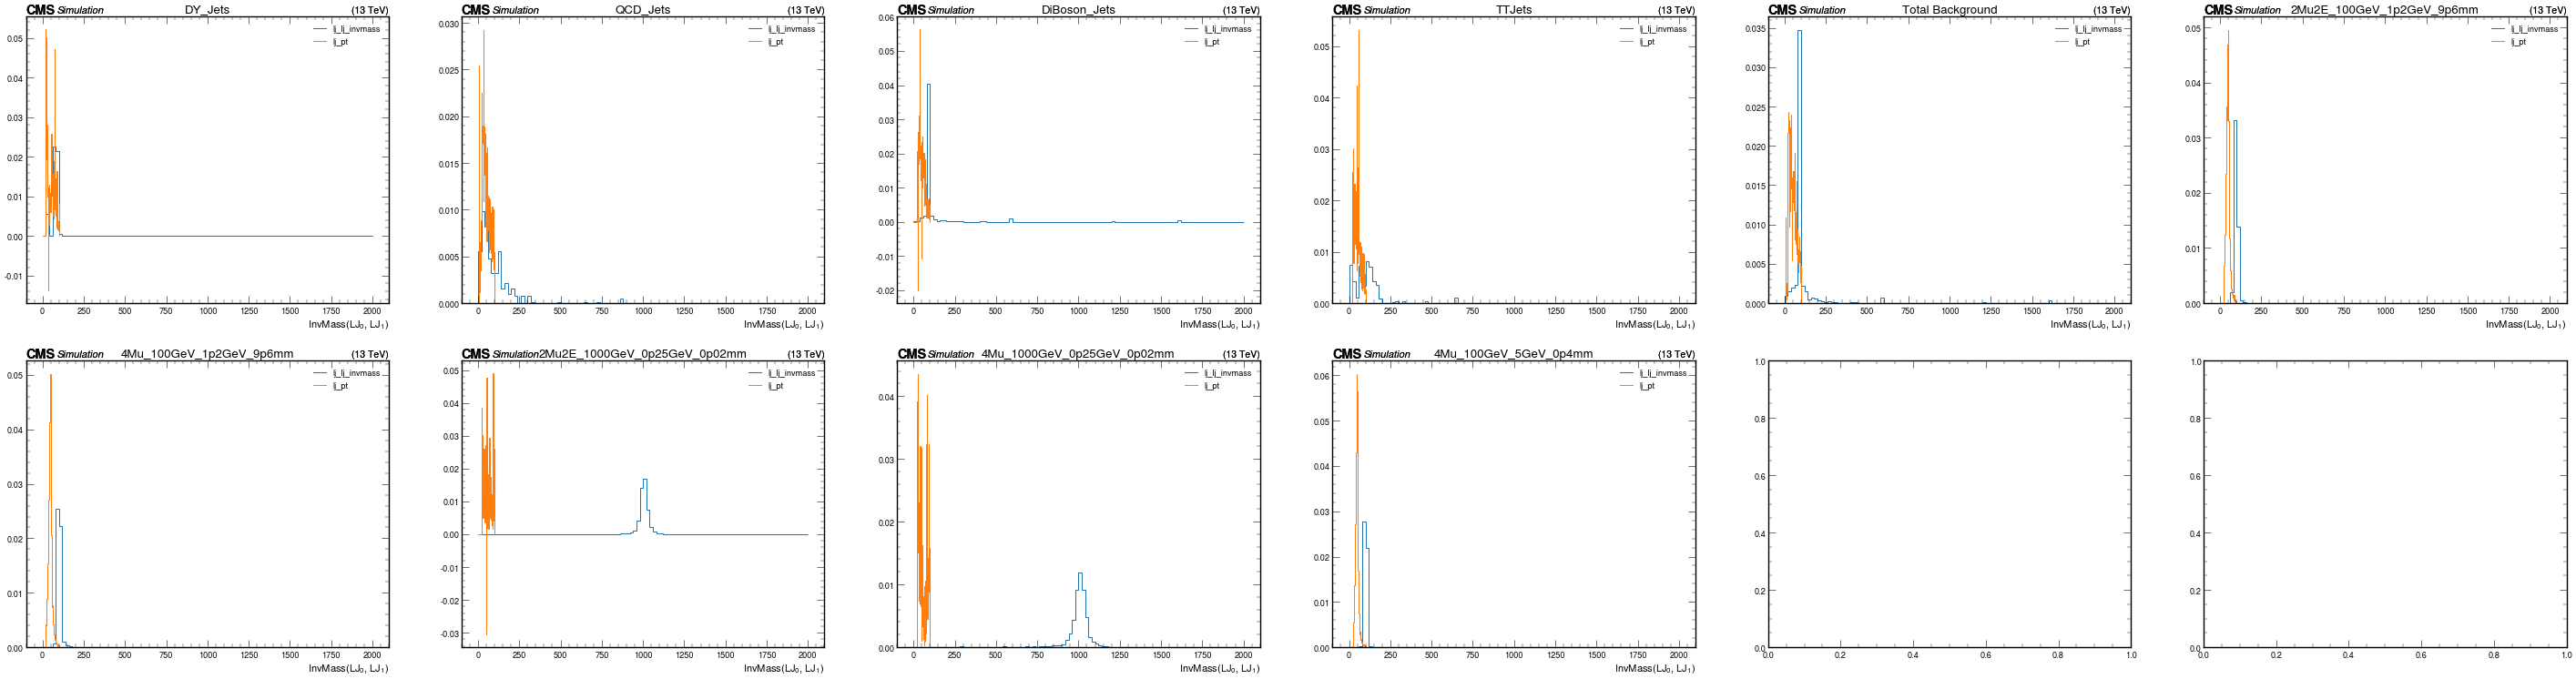

In [18]:
print(sample_list)

plotSamples(["lj_lj_invmass", "lj_pt"], "baseNoLj", False, True)

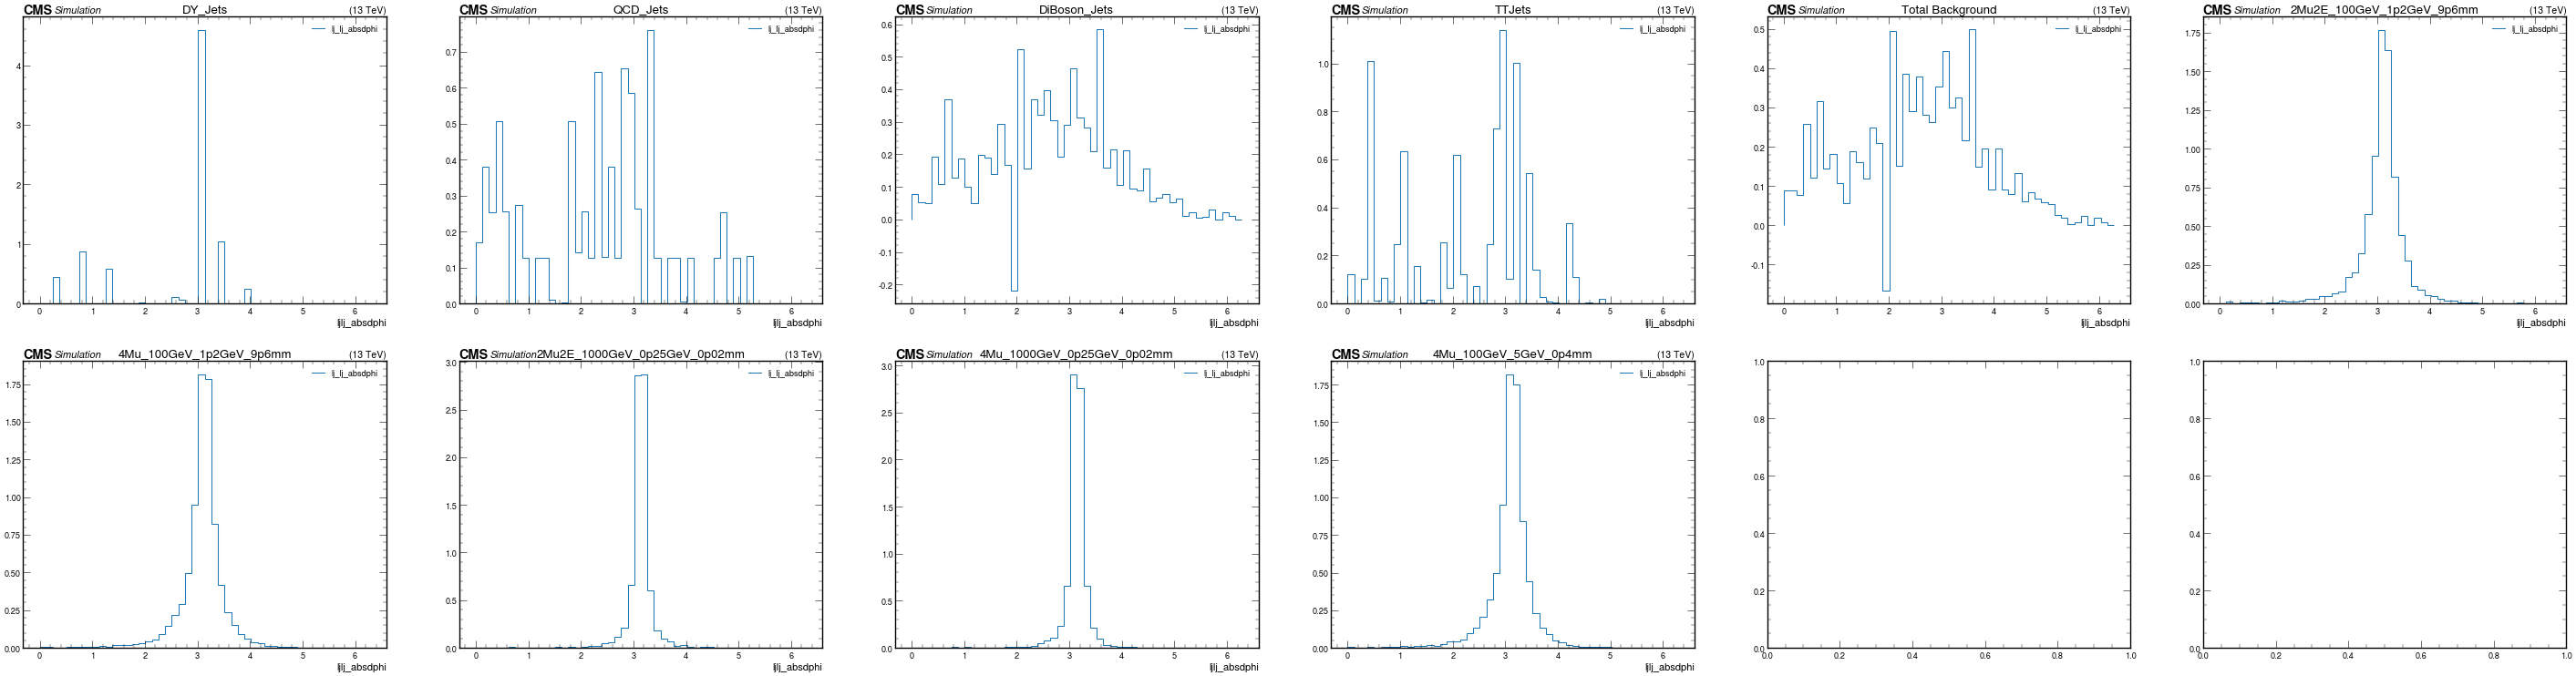

In [19]:
plotSamples(["lj_lj_absdphi"], "baseNoLj", False, True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f57f1045850>, errorbar=None, legend_artist=None)]

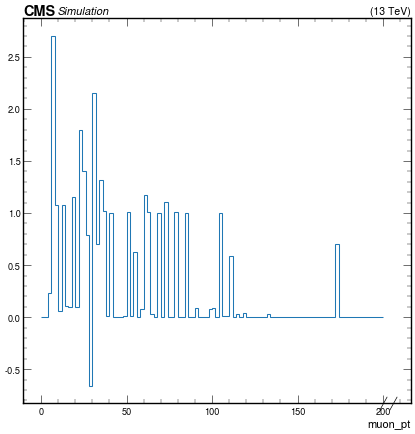

In [20]:
utilities.plot(QCD_Hists["muon_pt"]["2mu2e", :], yerr=False, density=False)

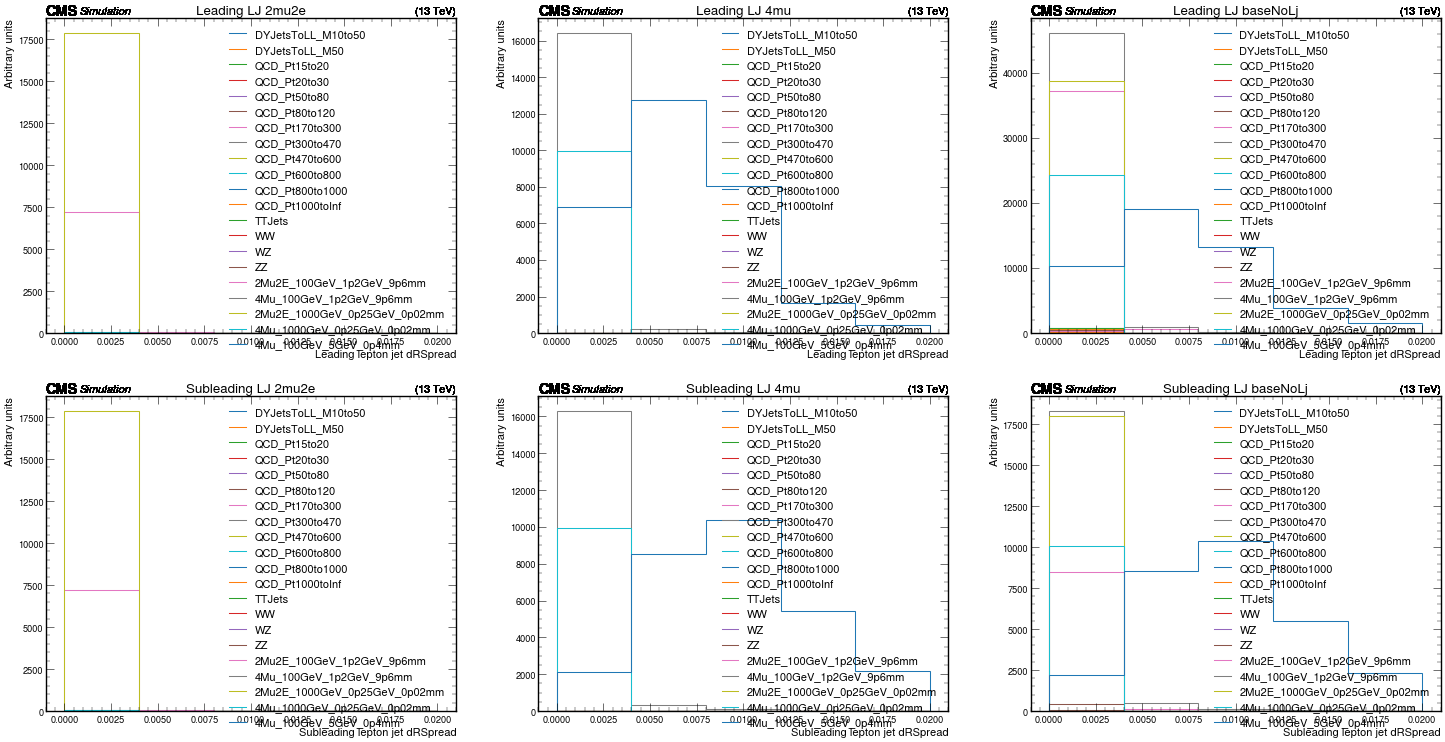

In [21]:
nrow = 2
ncol = 3
nplots = nrow*ncol

plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))

for i in range(1, ncol+1):
    plt.subplot(nrow, ncol, i)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["lj0_dRSpread"][channels[i-1], :.02j], yerr=False, density=False, flow='none')
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
    plt.legend(samples, loc=1, prop={'size': 16})
    plt.title("Leading LJ " + channels[i-1])
    
for i in range(1, ncol+1):
    plt.subplot(nrow, ncol, i+ncol)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["lj1_dRSpread"][channels[i-1], :.02j], yerr=False, density=False, flow='none')
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
    plt.legend(samples, loc=1, prop={'size': 16})
    plt.title("Subleading LJ " + channels[i-1])

In [22]:
if 0:
    nplots = 2
    plt.subplots(1, nplots, figsize=(nplots*12, 10))
    plt.subplot(1, nplots, 1)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["muon_n"][channels[2], :], density=True)
        # plt.legend(masses, title="DM bound state mass", alignment="left")
        plt.ylabel("Arbitrary units")
    plt.subplot(1, nplots, 2)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["electron_n"][channels[2], :], density=True)
        #plt.legend(masses, title="DM bound state mass", alignment="left")
        plt.ylabel("Arbitrary units")

In [23]:
samples_used = []
cutflows_used = []

if True:
    samples_used.append("Background")
    init_cutflow = bg_Cutflow["4mu"]
else:
    init_sample = samples[0]
    init_cutflow = out[init_sample]["cutflow"]["4mu"]
    
for sample in samples:
    if sample[0] == '2' or sample[0] == '4':
        samples_used.append(sample)
        cutflows_used.append(out[sample]["cutflow"]["4mu"])
#if samples_used[0][0] == '2' or samples_used == '4':
#    cutflows_used.remove(out[init_sample]["cutflow"]["4mu"])
print(cutflows_used)
init_cutflow.print_multi_table(cutflows_used, samples_used, True, title="Title")

[<sidm.tools.cutflow.Cutflow object at 0x7f58002b18b0>, <sidm.tools.cutflow.Cutflow object at 0x7f5800345d60>, <sidm.tools.cutflow.Cutflow object at 0x7f580039a220>, <sidm.tools.cutflow.Cutflow object at 0x7f580104cca0>, <sidm.tools.cutflow.Cutflow object at 0x7f580036b6a0>]
Title
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cut name          % cuts:                      % cuts:                    % cuts:                         % cuts:                       % cuts:                  % cuts:
                Background    2Mu2E_100GeV_1p2GeV_9p6mm    4Mu_100GeV_1p2GeV_9p6mm    2Mu2E_1000GeV_0p25GeV_0p02mm    4Mu_1000GeV_0p25GeV_0p02mm    4Mu_100GeV_5GeV_0p4mm
------------  ------------  ---------------------------  -------------------------  ------------------------------  ----------------------------  ---------

In [24]:
sample_used = "4Mu_100GeV_1p2GeV_9p6mm"
cut_samples = [
    "4Mu_1000GeV_0p25GeV_0p02mm",
    "4Mu_100GeV_5GeV_0p4mm"
]
headers = [sample_used]
cut_used = out[sample_used]["cutflow"]["baseNoLj"]
cutflow_list = []
for sample in cut_samples:
    cutflow_list.append(out[sample]["cutflow"]["baseNoLj"])
    headers.append(sample)
    
    
cut_used.print_multi_table(cutflow_list, headers, False, False, "Cuts in SIDM samples")

cut_used.print_multi_table(cutflow_list, headers, True, False, "Fractional SIDM cuts")

Cuts in SIDM samples
-------------------------------------------------------------------------------------------------------------------------------------
cut name                   Total cuts:                   Total cuts:              Total cuts:
                4Mu_100GeV_1p2GeV_9p6mm    4Mu_1000GeV_0p25GeV_0p02mm    4Mu_100GeV_5GeV_0p4mm
------------  -------------------------  ----------------------------  -----------------------
No selection                   47412.98                      24352.67                 49433.84
PV filter                      47412.98                      24352.67                 49433.84
Cosmic veto                    47360.98                      24346.38                 49341.18

Fractional SIDM cuts
-------------------------------------------------------------------------------------------------------------------------
cut name                       % cuts:                       % cuts:                  % cuts:
                4Mu_100GeV_1p2GeV_9p6m

In [25]:
cutflows_4mu = []
if 1:  
    cutflows_4mu.append(DY_Cutflow["4mu"])
    cutflows_4mu.append(QCD_Cutflow["4mu"])
    cutflows_4mu.append(DiBoson_Cutflow["4mu"])
    cutflows_4mu.append(TT_Cutflow["4mu"])
init_cutflow = bg_Cutflow["4mu"]
headers = [
        "Bg 4mu", "DY 4mu", "QCD 4mu", "DB 4mu", "TTbar 4mu"
]
init_cutflow.print_multi_table(cutflows_4mu, headers, False, False, title="Background Sample Types")
init_cutflow.print_multi_table(cutflows_4mu, headers, True, False)

Background Sample Types
-----------------------------------------------------------------------------------------------------------------------------------
cut name        Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                      Bg 4mu          DY 4mu         QCD 4mu          DB 4mu       TTbar 4mu
------------  --------------  --------------  --------------  --------------  --------------
No selection         7310.69          789.28         5197.20           61.69          862.96
PV filter            7310.69          789.28         5197.20           61.69          862.96
Cosmic veto          7308.69          789.28         5195.20           61.69          862.96
>=2 LJs               387.65            1.77           20.40           41.66            6.86
4mu                     0.38            0.00            0.00            0.00            0.00


cut name        % cuts:     % cuts:     % cuts:     % cuts:      % cuts:
                  Bg 4mu  

In [26]:
cutflows_2mu2e = []
if 1:  
    cutflows_2mu2e.append(DY_Cutflow["2mu2e"])
    cutflows_2mu2e.append(QCD_Cutflow["2mu2e"])
    cutflows_2mu2e.append(DiBoson_Cutflow["2mu2e"])
    cutflows_2mu2e.append(TT_Cutflow["2mu2e"])
init_cutflow = bg_Cutflow["2mu2e"]
headers = [
        "Bg 2mu2e", "DY 2mu2e", "QCD 2mu2e", "DB 2mu2e", "TTbar 2mu2e"
]
init_cutflow.print_multi_table(cutflows_2mu2e, headers, False, False)
init_cutflow.print_multi_table(cutflows_2mu2e, headers, True, False)


cut name        Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                    Bg 2mu2e        DY 2mu2e       QCD 2mu2e        DB 2mu2e     TTbar 2mu2e
------------  --------------  --------------  --------------  --------------  --------------
No selection         7310.69          789.28         5197.20           61.69          862.96
PV filter            7310.69          789.28         5197.20           61.69          862.96
Cosmic veto          7308.69          789.28         5195.20           61.69          862.96
>=2 LJs               387.65            1.77           20.40           41.66            6.86
2mu2e                  38.06            1.65            8.08           21.22            2.01


cut name        % cuts:     % cuts:      % cuts:     % cuts:        % cuts:
                Bg 2mu2e    DY 2mu2e    QCD 2mu2e    DB 2mu2e    TTbar 2mu2e
------------  ----------  ----------  -----------  ----------  -------------
No selection      100.00

In [27]:
print("2mu2e Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.\n\n")
cutflows_2mu2e = []
if 1:  
    cutflows_2mu2e.append(DY_Cutflow["2mu2e"])
    cutflows_2mu2e.append(QCD_Cutflow["2mu2e"])
    cutflows_2mu2e.append(DiBoson_Cutflow["2mu2e"])
    cutflows_2mu2e.append(TT_Cutflow["2mu2e"])
init_cutflow = bg_Cutflow["2mu2e"]
headers = [
        "Bg 2mu2e", "DY 2mu2e", "QCD 2mu2e", "DB 2mu2e", "TTbar 2mu2e"
]
init_cutflow.print_multi_table(cutflows_2mu2e, headers, False, False)
init_cutflow.print_multi_table(cutflows_2mu2e, headers, True, False)
temp = [bg_Cutflow["2mu2e"].cut_breakdown()]
for cuts in cutflows_2mu2e:
    temp.append(cuts.cut_breakdown())
samples = ["Total Background", "DY Jets", "QCD Jets", "DB Jets", "TT Jets"]
cuts = ["No selection", "PV filter", "Cosmic veto", ">=2 LJs", "2mu2e"]
test = cutflows_2mu2e[0].cut_breakdown(giveCuts=True)
print(test)
for i in range(len(temp)):
    print(str(temp[i]) + ' \n')

2mu2e Analysis -- shows the cutflow tables for both the total events cut and the fractional events, then plots cutflow over each cut.



cut name        Total cuts:     Total cuts:     Total cuts:     Total cuts:     Total cuts:
                    Bg 2mu2e        DY 2mu2e       QCD 2mu2e        DB 2mu2e     TTbar 2mu2e
------------  --------------  --------------  --------------  --------------  --------------
No selection         7310.69          789.28         5197.20           61.69          862.96
PV filter            7310.69          789.28         5197.20           61.69          862.96
Cosmic veto          7308.69          789.28         5195.20           61.69          862.96
>=2 LJs               387.65            1.77           20.40           41.66            6.86
2mu2e                  38.06            1.65            8.08           21.22            2.01


cut name        % cuts:     % cuts:      % cuts:     % cuts:        % cuts:
                Bg 2mu2e    DY 2mu2e    QC

Text(0.5, 1.0, 'Events cut by selection')

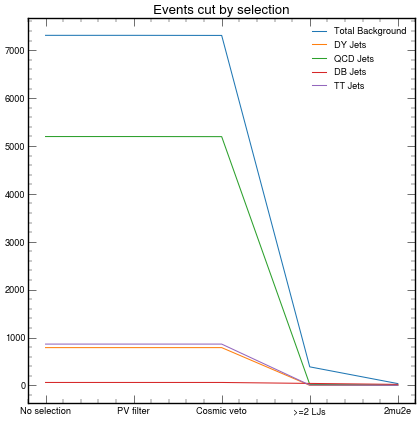

In [28]:
for i in range(len(temp)):
    plt.plot(test, temp[i])
plt.legend(samples)
plt.title("Events cut by selection")